<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Benchmark-pqlite" data-toc-modified-id="Benchmark-pqlite-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Benchmark pqlite</a></span><ul class="toc-item"><li><span><a href="#Time" data-toc-modified-id="Time-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Time</a></span></li><li><span><a href="#Quality" data-toc-modified-id="Quality-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Quality</a></span><ul class="toc-item"><li><span><a href="#Plotting-pq-neighbors-vs-true-neighbors" data-toc-modified-id="Plotting-pq-neighbors-vs-true-neighbors-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Plotting <code>pq neighbors</code> vs <code>true neighbors</code></a></span></li></ul></li><li><span><a href="#precision,-recall,-query_time-vs-n_subvectors-&amp;--n_cells" data-toc-modified-id="precision,-recall,-query_time-vs-n_subvectors-&amp;--n_cells-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span><code>precision, recall, query_time</code> vs <code>n_subvectors</code> &amp;  <code>n_cells</code></a></span></li></ul></li></ul></div>

## Benchmark pqlite

In [41]:
%load_ext autoreload
%autoreload 2

In [105]:
!rm -rf data/

In [43]:
import pqlite
pqlite.__path__
import time

import jina
from jina.math.distance import cdist

import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [44]:
import random
import numpy as np
from pqlite import PQLite

#N = 100_000 # number of data points
Nt = 12_500 
Nq = 1
D = 128 # dimentionality / number of features
top_k = 100
n_cells = 18
n_subvectors = 128

# 2,000 128-dim vectors for training
np.random.seed(123)
Xtr, Xte = train_test_split(make_blobs(n_samples = Nt, n_features = D)[0].astype(np.float32), test_size=20)
#Xt = np.random.random((Nt, D)).astype(np.float32)  

# the column schema: (name:str, dtype:type, create_index: bool)
pq = PQLite(dim=D, 
            n_cells=n_cells,
            n_subvectors=n_subvectors, 
            columns=[('x',float)])

pq.pq_codec.fit(Xtr)

2021-12-10 16:43:38.004 | INFO     | pqlite.index:__init__:89 - Initialize VQ codec (K=18)
2021-12-10 16:43:38.005 | INFO     | pqlite.index:__init__:99 - Initialize PQ codec (n_subvectors=128)


In [47]:
from jina import Document, DocumentArray

da = DocumentArray([Document(id=f'{i}', embedding=Xtr[i]) for i in range(len(Xtr))])
pq.train(Xtr)
pq.index(da)

2021-12-10 16:45:57.491 | INFO     | pqlite.index:train:141 - Start training VQ codec (K=18) with 12480 data...
2021-12-10 16:45:57.900 | INFO     | pqlite.index:train:147 - Start training PQ codec (n_subvectors=128) with 12480 data...
2021-12-10 16:47:32.244 | INFO     | pqlite.index:train:152 - The pqlite is successfully trained!
2021-12-10 16:47:32.244 | INFO     | pqlite.index:dump_model:359 - Save the trained parameters to data/bb79b2424c66ca6ba5a8c46814345738
2021-12-10 16:47:33.980 | DEBUG    | pqlite.container:insert:224 - => 12480 new docs added


In [48]:
Nq = 1
query_da = DocumentArray([Document(embedding=Xte[10])])

# without filtering
#pq.search(query_da, limit=5)

In [49]:
pq.search(query_da,  limit=top_k)

### Time

In [50]:
%timeit pq._search(Xte[[10]],  limit=top_k)

44.4 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [51]:
%timeit pq.search(query_da,  limit=top_k)

47.1 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [52]:
%timeit res = cdist(Xte[[10]], Xtr, metric='euclidean')

2.39 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Quality

Manually observing slices of a high dimensional space it seems that the
retrieved items from pqlite are nearby the query and the best values from the exact and exhaustive distance computations.

In [53]:
def _precision(predicted, relevant, eval_at):
    """
    fraction of retrieved documents that are relevant to the query
    """
    if eval_at == 0:
        return 0.0
    predicted_at_k = predicted[:eval_at]
    n_predicted_and_relevant = len(set(predicted_at_k).intersection(set(relevant)))

    return n_predicted_and_relevant / len(predicted)

def _recall(predicted, relevant, eval_at):
    """
    fraction of the relevant documents that are successfully retrieved
    """
    if eval_at == 0:
        return 0.0
    predicted_at_k = predicted[:eval_at]
    n_predicted_and_relevant = len(set(predicted_at_k).intersection(set(relevant)))
    return n_predicted_and_relevant/ len(relevant)


In [54]:
query = Xte[[11]]  
true_distances = cdist(query, Xtr, metric='euclidean').flatten()

true_ids = np.argsort(true_distances)[0:top_k]
true_dists = true_distances[true_ids]

In [55]:
true_ids.sort()
true_ids

array([    0,   192,   300,   371,   545,   677,   767,   813,   933,
        1000,  1131,  1219,  1308,  1389,  1590,  1615,  1686,  1713,
        1740,  1802,  1943,  2372,  2447,  2618,  2719,  2921,  3010,
        3258,  3337,  3418,  3926,  3967,  4140,  4376,  4612,  4625,
        4661,  5243,  5433,  5491,  5534,  5619,  5657,  5693,  5699,
        5875,  6016,  6413,  6440,  6511,  6624,  6772,  6825,  7103,
        7125,  7155,  7948,  8025,  8052,  8098,  8251,  8327,  8366,
        8551,  8572,  8931,  9087,  9094,  9239,  9356,  9739,  9867,
        9877,  9952,  9978,  9987, 10077, 10174, 10187, 10214, 10277,
       10457, 10488, 10982, 11059, 11077, 11083, 11115, 11172, 11280,
       11379, 11382, 11445, 11641, 11911, 12001, 12194, 12212, 12234,
       12342])

In [88]:
pq_dists, pq_ids = pq._search(query,  k=top_k)
pq_ids = pq_ids[0]

In [89]:
pq_ids

array([    0,   767,  4612,  1686,  7103, 11280, 10457, 12212,  2372,
        9356])

In [90]:
print(_precision(true_ids, pq_ids, top_k))
print(_recall(true_ids, pq_ids, top_k))

0.1
1.0


#### Plotting `pq neighbors` vs `true neighbors`

Here we should see orange and black dots close in the feature space (does not seem to work as expected).

In [95]:
import matplotlib.pyplot as plt

def paint_slice(Xtr, query, pq_ids, feat1, feat2):
    plt.scatter(Xtr[:,feat1], Xtr[:,feat2], color='blue', alpha=0.2)

    for pq_id in pq_ids:
        plt.scatter(Xtr[pq_id, feat1], Xtr[pq_id, feat2], color='black')

    for true_id in true_ids:
        plt.scatter(Xtr[true_id, feat1], Xtr[true_id, feat2], color='orange')

    plt.scatter(query[:, feat1], query[:, feat2], color='red')
    

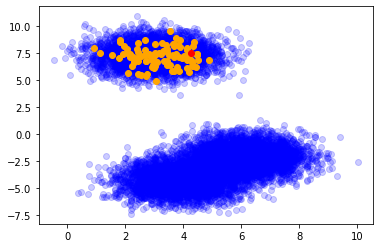

In [102]:
feat1, feat2 = 0, 1
paint_slice(Xtr, query, pq_ids, feat1, feat2)

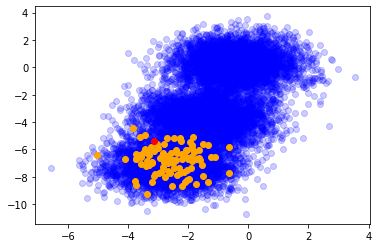

In [100]:
feat1, feat2 = 8, 100
paint_slice(Xtr, query, pq_ids, feat1, feat2)

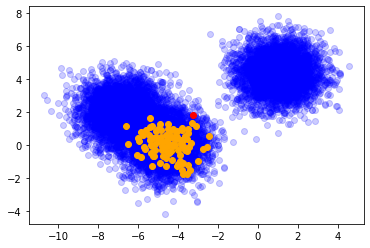

In [99]:
feat1, feat2 = 3,4
paint_slice(Xtr, query, pq_ids, feat1, feat2)


###  `precision, recall, query_time` vs `n_subvectors` &  `n_cells` 

In [108]:
import time
import numpy as np
from pqlite import PQLite

from jina.math.distance import cdist
from jina.math.helper import top_k as _top_k
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

def _precision(predicted, relevant, eval_at):
    """
    fraction of retrieved documents that are relevant to the query
    """
    if eval_at == 0:
        return 0.0
    predicted_at_k = predicted[:eval_at]
    n_predicted_and_relevant = len(set(predicted_at_k).intersection(set(relevant)))

    return n_predicted_and_relevant / len(predicted)

def _recall(predicted, relevant, eval_at):
    """
    fraction of the relevant documents that are successfully retrieved
    """
    if eval_at == 0:
        return 0.0
    predicted_at_k = predicted[:eval_at]
    n_predicted_and_relevant = len(set(predicted_at_k).intersection(set(relevant)))
    return n_predicted_and_relevant/ len(relevant)

def evaluate(predicts, relevants, eval_at):
    recall = 0
    precision = 0
    for _predict, _relevant in zip(predicts, relevants):
        _predict = np.array([int(x) for x in _predict])
        recall += _recall(_predict, _relevant, top_k)
        precision += _precision(_predict, _relevant, top_k)

    return recall / len(predicts), precision / len(predicts)


#N = 100_000 # number of data points
Nt = 10_000
Nq = 1
D = 128 # dimentionality / number of features
top_k = 10
n_cells = 64
n_subvectors = 64
n_queries = 1000

# 2,000 128-dim vectors for training
np.random.seed(123)
Xtr, Xte = train_test_split(make_blobs(n_samples = Nt, n_features = D)[0].astype(np.float32), test_size=20)
print(f'Xtr: {Xtr.shape} vs Xte: {Xte.shape}')

precision_per_query = []
recall_per_query = []
results = []

for n_cells in [8, 16, 32, 64, 128]:
    for n_subvectors in [32, 64, 128]:
        !rm -rf data/
        pq = PQLite(dim=D,
                    n_cells=n_cells,
                    n_subvectors=n_subvectors)
        
        t0 = time.time()
        pq.train(Xtr[:20480])
        train_time = abs(time.time() - t0)

        t0 = time.time()
        
        Xtr_da = DocumentArray([Document(id=f'{i}', embedding=Xtr[i]) for i in range(len(Xtr))])
        pq.index(Xtr_da, ids=list(range(len(Xtr))))
        index_time = abs(t0 - time.time())

        dists = cdist(Xte, Xtr, metric='euclidean')
        true_dists, true_ids = _top_k(dists, top_k, descending=False)
        
        t0 = time.time()
        pq_dists, pq_ids = pq._search(Xte, limit=top_k)
        query_time = abs(t0 - time.time())
        recall, precision = evaluate(pq_ids, true_ids, top_k)

        results_dict = {'precision': precision,
                        'recall': recall,
                        'train_time': train_time,
                        'index_time': index_time,
                        'query_time': query_time,
                        'indexer_hyperparams': {'n_cells': n_cells,
                                                'n_subvectors': n_subvectors}
                        }
        print(results_dict)

        results.append(results_dict)

Xtr: (9980, 128) vs Xte: (20, 128)


2021-12-10 16:53:13.145 | INFO     | pqlite.index:__init__:89 - Initialize VQ codec (K=8)
2021-12-10 16:53:13.146 | INFO     | pqlite.index:__init__:99 - Initialize PQ codec (n_subvectors=32)
2021-12-10 16:53:13.158 | INFO     | pqlite.index:train:141 - Start training VQ codec (K=8) with 9980 data...
2021-12-10 16:53:13.435 | INFO     | pqlite.index:train:147 - Start training PQ codec (n_subvectors=32) with 9980 data...
2021-12-10 16:53:34.875 | INFO     | pqlite.index:train:152 - The pqlite is successfully trained!
2021-12-10 16:53:34.876 | INFO     | pqlite.index:dump_model:359 - Save the trained parameters to data/d1304f5ee4600f004f64117d6ce12ebb
2021-12-10 16:53:35.639 | DEBUG    | pqlite.container:insert:224 - => 9980 new docs added


{'precision': 0.45500000000000007, 'recall': 0.45500000000000007, 'train_time': 21.7206130027771, 'index_time': 0.7612957954406738, 'query_time': 0.22287511825561523, 'indexer_hyperparams': {'n_cells': 8, 'n_subvectors': 32}}


2021-12-10 16:53:35.994 | INFO     | pqlite.index:__init__:89 - Initialize VQ codec (K=8)
2021-12-10 16:53:35.995 | INFO     | pqlite.index:__init__:99 - Initialize PQ codec (n_subvectors=64)
2021-12-10 16:53:36.012 | INFO     | pqlite.index:train:141 - Start training VQ codec (K=8) with 9980 data...
2021-12-10 16:53:36.278 | INFO     | pqlite.index:train:147 - Start training PQ codec (n_subvectors=64) with 9980 data...
2021-12-10 16:54:17.965 | INFO     | pqlite.index:train:152 - The pqlite is successfully trained!
2021-12-10 16:54:17.965 | INFO     | pqlite.index:dump_model:359 - Save the trained parameters to data/626305e7606537598688ad160806d69f
2021-12-10 16:54:18.950 | DEBUG    | pqlite.container:insert:224 - => 9980 new docs added


{'precision': 0.7550000000000001, 'recall': 0.7550000000000001, 'train_time': 41.95451092720032, 'index_time': 0.9851388931274414, 'query_time': 0.26849794387817383, 'indexer_hyperparams': {'n_cells': 8, 'n_subvectors': 64}}


2021-12-10 16:54:19.348 | INFO     | pqlite.index:__init__:89 - Initialize VQ codec (K=8)
2021-12-10 16:54:19.349 | INFO     | pqlite.index:__init__:99 - Initialize PQ codec (n_subvectors=128)
2021-12-10 16:54:19.370 | INFO     | pqlite.index:train:141 - Start training VQ codec (K=8) with 9980 data...
2021-12-10 16:54:19.749 | INFO     | pqlite.index:train:147 - Start training PQ codec (n_subvectors=128) with 9980 data...
2021-12-10 16:55:31.617 | INFO     | pqlite.index:train:152 - The pqlite is successfully trained!
2021-12-10 16:55:31.617 | INFO     | pqlite.index:dump_model:359 - Save the trained parameters to data/f33efae3f283d85b6afef29d4305b0f6
2021-12-10 16:55:32.887 | DEBUG    | pqlite.container:insert:224 - => 9980 new docs added


{'precision': 0.9400000000000001, 'recall': 0.9400000000000001, 'train_time': 72.24841713905334, 'index_time': 1.2695119380950928, 'query_time': 0.36830782890319824, 'indexer_hyperparams': {'n_cells': 8, 'n_subvectors': 128}}


2021-12-10 16:55:33.390 | INFO     | pqlite.index:__init__:89 - Initialize VQ codec (K=16)
2021-12-10 16:55:33.391 | INFO     | pqlite.index:__init__:99 - Initialize PQ codec (n_subvectors=32)
2021-12-10 16:55:33.420 | INFO     | pqlite.index:train:141 - Start training VQ codec (K=16) with 9980 data...
2021-12-10 16:55:33.812 | INFO     | pqlite.index:train:147 - Start training PQ codec (n_subvectors=32) with 9980 data...
2021-12-10 16:55:54.788 | INFO     | pqlite.index:train:152 - The pqlite is successfully trained!
2021-12-10 16:55:54.789 | INFO     | pqlite.index:dump_model:359 - Save the trained parameters to data/45f59be7052d7061f734b2b55ce6df0e
2021-12-10 16:55:56.034 | DEBUG    | pqlite.container:insert:224 - => 9980 new docs added


{'precision': 0.425, 'recall': 0.425, 'train_time': 21.371039152145386, 'index_time': 1.2443852424621582, 'query_time': 0.7414536476135254, 'indexer_hyperparams': {'n_cells': 16, 'n_subvectors': 32}}


2021-12-10 16:55:56.911 | INFO     | pqlite.index:__init__:89 - Initialize VQ codec (K=16)
2021-12-10 16:55:56.912 | INFO     | pqlite.index:__init__:99 - Initialize PQ codec (n_subvectors=64)
2021-12-10 16:55:56.959 | INFO     | pqlite.index:train:141 - Start training VQ codec (K=16) with 9980 data...
2021-12-10 16:55:57.468 | INFO     | pqlite.index:train:147 - Start training PQ codec (n_subvectors=64) with 9980 data...
2021-12-10 16:56:40.350 | INFO     | pqlite.index:train:152 - The pqlite is successfully trained!
2021-12-10 16:56:40.351 | INFO     | pqlite.index:dump_model:359 - Save the trained parameters to data/cd85824bf658d77a3ce90a7a42a14daf
2021-12-10 16:56:41.476 | DEBUG    | pqlite.container:insert:224 - => 9980 new docs added


{'precision': 0.8, 'recall': 0.8, 'train_time': 43.39419198036194, 'index_time': 1.124485731124878, 'query_time': 0.5442020893096924, 'indexer_hyperparams': {'n_cells': 16, 'n_subvectors': 64}}


2021-12-10 16:56:42.152 | INFO     | pqlite.index:__init__:89 - Initialize VQ codec (K=16)
2021-12-10 16:56:42.153 | INFO     | pqlite.index:__init__:99 - Initialize PQ codec (n_subvectors=128)
2021-12-10 16:56:42.191 | INFO     | pqlite.index:train:141 - Start training VQ codec (K=16) with 9980 data...
2021-12-10 16:56:42.616 | INFO     | pqlite.index:train:147 - Start training PQ codec (n_subvectors=128) with 9980 data...
2021-12-10 16:57:56.084 | INFO     | pqlite.index:train:152 - The pqlite is successfully trained!
2021-12-10 16:57:56.085 | INFO     | pqlite.index:dump_model:359 - Save the trained parameters to data/24f8df04c973b4a2e6733b8f79981087
2021-12-10 16:57:57.583 | DEBUG    | pqlite.container:insert:224 - => 9980 new docs added


{'precision': 0.9550000000000001, 'recall': 0.9550000000000001, 'train_time': 73.8950867652893, 'index_time': 1.4972429275512695, 'query_time': 0.8586359024047852, 'indexer_hyperparams': {'n_cells': 16, 'n_subvectors': 128}}


2021-12-10 16:57:58.574 | INFO     | pqlite.index:__init__:89 - Initialize VQ codec (K=32)
2021-12-10 16:57:58.575 | INFO     | pqlite.index:__init__:99 - Initialize PQ codec (n_subvectors=32)
2021-12-10 16:57:58.641 | INFO     | pqlite.index:train:141 - Start training VQ codec (K=32) with 9980 data...
2021-12-10 16:57:59.265 | INFO     | pqlite.index:train:147 - Start training PQ codec (n_subvectors=32) with 9980 data...
2021-12-10 16:58:22.452 | INFO     | pqlite.index:train:152 - The pqlite is successfully trained!
2021-12-10 16:58:22.452 | INFO     | pqlite.index:dump_model:359 - Save the trained parameters to data/6e6169129ace0166eaa443eb03643189
2021-12-10 16:58:23.505 | DEBUG    | pqlite.container:insert:224 - => 9980 new docs added


{'precision': 0.45999999999999996, 'recall': 0.45999999999999996, 'train_time': 23.813657999038696, 'index_time': 1.0515470504760742, 'query_time': 0.9839298725128174, 'indexer_hyperparams': {'n_cells': 32, 'n_subvectors': 32}}


2021-12-10 16:58:24.628 | INFO     | pqlite.index:__init__:89 - Initialize VQ codec (K=32)
2021-12-10 16:58:24.629 | INFO     | pqlite.index:__init__:99 - Initialize PQ codec (n_subvectors=64)
2021-12-10 16:58:24.700 | INFO     | pqlite.index:train:141 - Start training VQ codec (K=32) with 9980 data...
2021-12-10 16:58:25.102 | INFO     | pqlite.index:train:147 - Start training PQ codec (n_subvectors=64) with 9980 data...
2021-12-10 16:59:12.110 | INFO     | pqlite.index:train:152 - The pqlite is successfully trained!
2021-12-10 16:59:12.111 | INFO     | pqlite.index:dump_model:359 - Save the trained parameters to data/0805ec37d9c6b2e3541df4c983c6b57d
2021-12-10 16:59:13.126 | DEBUG    | pqlite.container:insert:224 - => 9980 new docs added


{'precision': 0.8100000000000002, 'recall': 0.8100000000000002, 'train_time': 47.41264009475708, 'index_time': 1.0145530700683594, 'query_time': 1.013725996017456, 'indexer_hyperparams': {'n_cells': 32, 'n_subvectors': 64}}


2021-12-10 16:59:14.278 | INFO     | pqlite.index:__init__:89 - Initialize VQ codec (K=32)
2021-12-10 16:59:14.279 | INFO     | pqlite.index:__init__:99 - Initialize PQ codec (n_subvectors=128)
2021-12-10 16:59:14.353 | INFO     | pqlite.index:train:141 - Start training VQ codec (K=32) with 9980 data...
2021-12-10 16:59:14.872 | INFO     | pqlite.index:train:147 - Start training PQ codec (n_subvectors=128) with 9980 data...
2021-12-10 17:00:23.623 | INFO     | pqlite.index:train:152 - The pqlite is successfully trained!
2021-12-10 17:00:23.624 | INFO     | pqlite.index:dump_model:359 - Save the trained parameters to data/d4b5ce5fb6c2ffe0121fa0863a53e26b
2021-12-10 17:00:25.018 | DEBUG    | pqlite.container:insert:224 - => 9980 new docs added


{'precision': 0.96, 'recall': 0.96, 'train_time': 69.27235388755798, 'index_time': 1.3933141231536865, 'query_time': 1.387444019317627, 'indexer_hyperparams': {'n_cells': 32, 'n_subvectors': 128}}


2021-12-10 17:00:26.545 | INFO     | pqlite.index:__init__:89 - Initialize VQ codec (K=64)
2021-12-10 17:00:26.546 | INFO     | pqlite.index:__init__:99 - Initialize PQ codec (n_subvectors=32)
2021-12-10 17:00:26.639 | INFO     | pqlite.index:train:141 - Start training VQ codec (K=64) with 9980 data...
2021-12-10 17:00:27.205 | INFO     | pqlite.index:train:147 - Start training PQ codec (n_subvectors=32) with 9980 data...
2021-12-10 17:00:46.900 | INFO     | pqlite.index:train:152 - The pqlite is successfully trained!
2021-12-10 17:00:46.900 | INFO     | pqlite.index:dump_model:359 - Save the trained parameters to data/6fdff810b2a3450f2c6d199086ad702d
2021-12-10 17:00:47.713 | DEBUG    | pqlite.container:insert:224 - => 9980 new docs added


{'precision': 0.4699999999999999, 'recall': 0.4699999999999999, 'train_time': 20.26306414604187, 'index_time': 0.8123030662536621, 'query_time': 1.5700819492340088, 'indexer_hyperparams': {'n_cells': 64, 'n_subvectors': 32}}


2021-12-10 17:00:49.425 | INFO     | pqlite.index:__init__:89 - Initialize VQ codec (K=64)
2021-12-10 17:00:49.427 | INFO     | pqlite.index:__init__:99 - Initialize PQ codec (n_subvectors=64)
2021-12-10 17:00:49.536 | INFO     | pqlite.index:train:141 - Start training VQ codec (K=64) with 9980 data...
2021-12-10 17:00:49.990 | INFO     | pqlite.index:train:147 - Start training PQ codec (n_subvectors=64) with 9980 data...
2021-12-10 17:01:29.490 | INFO     | pqlite.index:train:152 - The pqlite is successfully trained!
2021-12-10 17:01:29.491 | INFO     | pqlite.index:dump_model:359 - Save the trained parameters to data/a868cc5aa102be21a3dd1b6f8b9ec374
2021-12-10 17:01:30.530 | DEBUG    | pqlite.container:insert:224 - => 9980 new docs added


{'precision': 0.7950000000000002, 'recall': 0.7950000000000002, 'train_time': 39.95717978477478, 'index_time': 1.0383119583129883, 'query_time': 1.9283158779144287, 'indexer_hyperparams': {'n_cells': 64, 'n_subvectors': 64}}


2021-12-10 17:01:32.596 | INFO     | pqlite.index:__init__:89 - Initialize VQ codec (K=64)
2021-12-10 17:01:32.597 | INFO     | pqlite.index:__init__:99 - Initialize PQ codec (n_subvectors=128)
2021-12-10 17:01:32.721 | INFO     | pqlite.index:train:141 - Start training VQ codec (K=64) with 9980 data...
2021-12-10 17:01:33.262 | INFO     | pqlite.index:train:147 - Start training PQ codec (n_subvectors=128) with 9980 data...
2021-12-10 17:02:41.386 | INFO     | pqlite.index:train:152 - The pqlite is successfully trained!
2021-12-10 17:02:41.387 | INFO     | pqlite.index:dump_model:359 - Save the trained parameters to data/53fcfdf043b7f1e1886e2f67d2db315b
2021-12-10 17:02:42.844 | DEBUG    | pqlite.container:insert:224 - => 9980 new docs added


{'precision': 0.9350000000000002, 'recall': 0.9350000000000002, 'train_time': 68.66774678230286, 'index_time': 1.4564719200134277, 'query_time': 2.7429070472717285, 'indexer_hyperparams': {'n_cells': 64, 'n_subvectors': 128}}


2021-12-10 17:02:45.734 | INFO     | pqlite.index:__init__:89 - Initialize VQ codec (K=128)
2021-12-10 17:02:45.735 | INFO     | pqlite.index:__init__:99 - Initialize PQ codec (n_subvectors=32)
2021-12-10 17:02:45.954 | INFO     | pqlite.index:train:141 - Start training VQ codec (K=128) with 9980 data...
2021-12-10 17:02:46.539 | INFO     | pqlite.index:train:147 - Start training PQ codec (n_subvectors=32) with 9980 data...
2021-12-10 17:03:06.261 | INFO     | pqlite.index:train:152 - The pqlite is successfully trained!
2021-12-10 17:03:06.261 | INFO     | pqlite.index:dump_model:359 - Save the trained parameters to data/d9e21e6fe97193567a60d042917f23e0
2021-12-10 17:03:07.174 | DEBUG    | pqlite.container:insert:224 - => 9980 new docs added


{'precision': 0.5399999999999999, 'recall': 0.5399999999999999, 'train_time': 20.30864906311035, 'index_time': 0.9121379852294922, 'query_time': 3.0955798625946045, 'indexer_hyperparams': {'n_cells': 128, 'n_subvectors': 32}}


2021-12-10 17:03:10.419 | INFO     | pqlite.index:__init__:89 - Initialize VQ codec (K=128)
2021-12-10 17:03:10.420 | INFO     | pqlite.index:__init__:99 - Initialize PQ codec (n_subvectors=64)
2021-12-10 17:03:10.627 | INFO     | pqlite.index:train:141 - Start training VQ codec (K=128) with 9980 data...
2021-12-10 17:03:11.182 | INFO     | pqlite.index:train:147 - Start training PQ codec (n_subvectors=64) with 9980 data...
2021-12-10 17:03:50.667 | INFO     | pqlite.index:train:152 - The pqlite is successfully trained!
2021-12-10 17:03:50.668 | INFO     | pqlite.index:dump_model:359 - Save the trained parameters to data/8118e7af93ba02938d166bb2a557aa4d
2021-12-10 17:03:51.850 | DEBUG    | pqlite.container:insert:224 - => 9980 new docs added


{'precision': 0.7950000000000002, 'recall': 0.7950000000000002, 'train_time': 40.042699098587036, 'index_time': 1.1807379722595215, 'query_time': 3.7773728370666504, 'indexer_hyperparams': {'n_cells': 128, 'n_subvectors': 64}}


2021-12-10 17:03:55.777 | INFO     | pqlite.index:__init__:89 - Initialize VQ codec (K=128)
2021-12-10 17:03:55.779 | INFO     | pqlite.index:__init__:99 - Initialize PQ codec (n_subvectors=128)
2021-12-10 17:03:56.022 | INFO     | pqlite.index:train:141 - Start training VQ codec (K=128) with 9980 data...
2021-12-10 17:03:56.616 | INFO     | pqlite.index:train:147 - Start training PQ codec (n_subvectors=128) with 9980 data...
2021-12-10 17:05:05.761 | INFO     | pqlite.index:train:152 - The pqlite is successfully trained!
2021-12-10 17:05:05.761 | INFO     | pqlite.index:dump_model:359 - Save the trained parameters to data/cfe5f214259b790f13d7fb00c6c39203
2021-12-10 17:05:07.366 | DEBUG    | pqlite.container:insert:224 - => 9980 new docs added


{'precision': 0.95, 'recall': 0.95, 'train_time': 69.74145197868347, 'index_time': 1.6033689975738525, 'query_time': 5.468432903289795, 'indexer_hyperparams': {'n_cells': 128, 'n_subvectors': 128}}


In [109]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df.sort_values('recall', ascending=False)

,precision,recall,train_time,index_time,query_time,indexer_hyperparams
8,0.960,0.960,69.272354,1.393314,1.387444,"{'n_cells': 32, 'n_subvectors': 128}"
5,0.955,0.955,73.895087,1.497243,0.858636,"{'n_cells': 16, 'n_subvectors': 128}"
14,0.950,0.950,69.741452,1.603369,5.468433,"{'n_cells': 128, 'n_subvectors': 128}"
2,0.940,0.940,72.248417,1.269512,0.368308,"{'n_cells': 8, 'n_subvectors': 128}"
11,0.935,0.935,68.667747,1.456472,2.742907,"{'n_cells': 64, 'n_subvectors': 128}"
7,0.810,0.810,47.412640,1.014553,1.013726,"{'n_cells': 32, 'n_subvectors': 64}"
4,0.800,0.800,43.394192,1.124486,0.544202,"{'n_cells': 16, 'n_subvectors': 64}"
10,0.795,0.795,39.957180,1.038312,1.928316,"{'n_cells': 64, 'n_subvectors': 64}"
13,0.795,0.795,40.042699,1.180738,3.777373,"{'n_cells': 128, 'n_subvectors': 64}"
1,0.755,0.755,41.954511,0.985139,0.268498,"{'n_cells': 8, 'n_subvectors': 64}"
